In [1]:
import os
import torch
from torchvision import transforms
from collections import defaultdict
from src.utils import image_path_to_tensor
from PIL import Image
from tqdm import tqdm


/secondary/home/aayushg/miniconda3/envs/gsplat/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/secondary/home/aayushg/miniconda3/envs/gsplat/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dataset_path = "/secondary/home/aayushg/rl_gsplat/gsplat/src/data/small_mipnerf"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /secondary/home/aayushg/.cache/torch/hub/facebookresearch_dinov2_main
/secondary/home/aayushg/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/secondary/home/aayushg/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/secondary/home/aayushg/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
def preprocess(img_path: str) -> torch.tensor:
    input_image = Image.open(img_path)
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    return input_tensor

In [4]:
num_images = 0
encoded_images = []
orig_images = []
img_names = []
scene_to_encoded_imgs = defaultdict(list)

for img_name in tqdm(os.listdir(dataset_path)):
    scene_name = img_name.split('_')[0]
    full_path = os.path.join(dataset_path, img_name)
    with torch.no_grad():    
        preprocessed = preprocess(full_path)    
        encoded_img = img_encoder(preprocessed.unsqueeze(0)).squeeze(0).to(device)

    scene_to_encoded_imgs[scene_name].append(encoded_img)

100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


In [5]:
scene_to_encoded_imgs.keys()

dict_keys(['trex', 'fern', 'fortress', 'horns', 'flower', 'orchids', 'room', 'leaves'])

/tmp/ipykernel_680848/3441822330.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


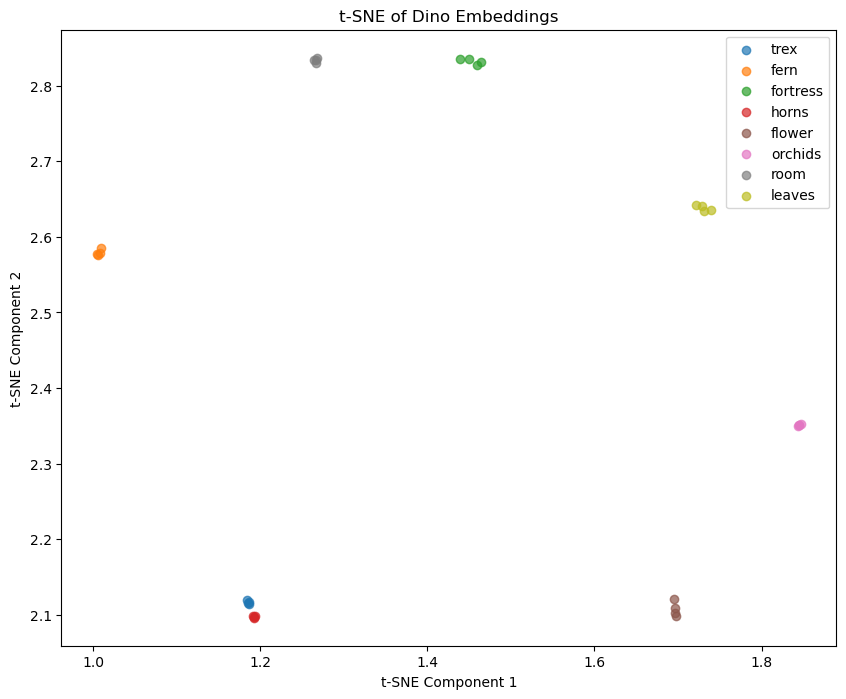

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten the list of encoded images and keep track of their scene names
all_encoded_imgs = []
scene_labels = []
for scene, encodings in scene_to_encoded_imgs.items():
    for encoding in encodings:
        all_encoded_imgs.append(encoding.cpu().numpy())
        scene_labels.append(scene)

# Convert to numpy array
all_encoded_imgs = np.array(all_encoded_imgs)
scene_names = set(scene_labels)
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_encoded_imgs)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))

# Create a color map
unique_scenes = list(scene_to_encoded_imgs.keys())
color_map = plt.cm.get_cmap('tab10')
colors = [color_map(i / len(unique_scenes)) for i in range(len(unique_scenes))]

# Create a scatter plot for each scene
for i, scene in enumerate(unique_scenes):
    scene_mask = np.array(scene_labels) == scene
    plt.scatter(tsne_results[scene_mask, 0], tsne_results[scene_mask, 1], 
                c=[colors[i]], label=scene, alpha=0.7)

plt.title('t-SNE of Dino Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


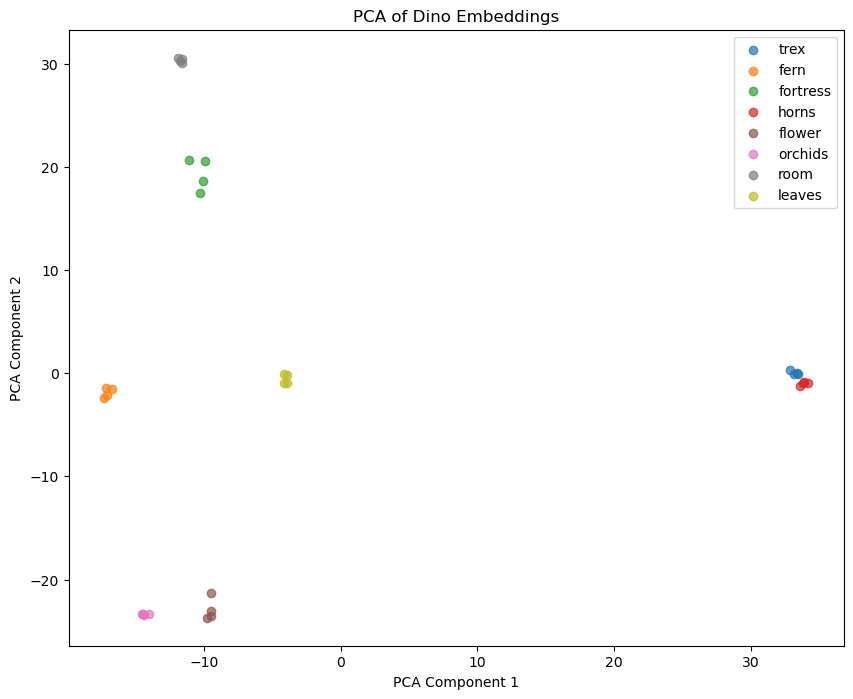

In [10]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_encoded_imgs)

# Plot the PCA results
plt.figure(figsize=(10, 8))

# Create a scatter plot for each scene
for i, scene in enumerate(unique_scenes):
    scene_mask = np.array(scene_labels) == scene
    plt.scatter(pca_results[scene_mask, 0], pca_results[scene_mask, 1], 
                c=[colors[i]], label=scene, alpha=0.7)

plt.title('PCA of Dino Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [9]:
import umap
from umap import UMAP

# Perform UMAP
umap_reducer = UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(all_encoded_imgs)

# Plot the UMAP results
plt.figure(figsize=(10, 8))

# Create a scatter plot for each scene
for i, scene in enumerate(unique_scenes):
    scene_mask = np.array(scene_labels) == scene
    plt.scatter(umap_results[scene_mask, 0], umap_results[scene_mask, 1], 
                c=[colors[i]], label=scene, alpha=0.7)

plt.title('UMAP of Dino Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


ImportError: cannot import name 'UMAP' from 'umap' (/secondary/home/aayushg/miniconda3/envs/gsplat/lib/python3.9/site-packages/umap/__init__.py)

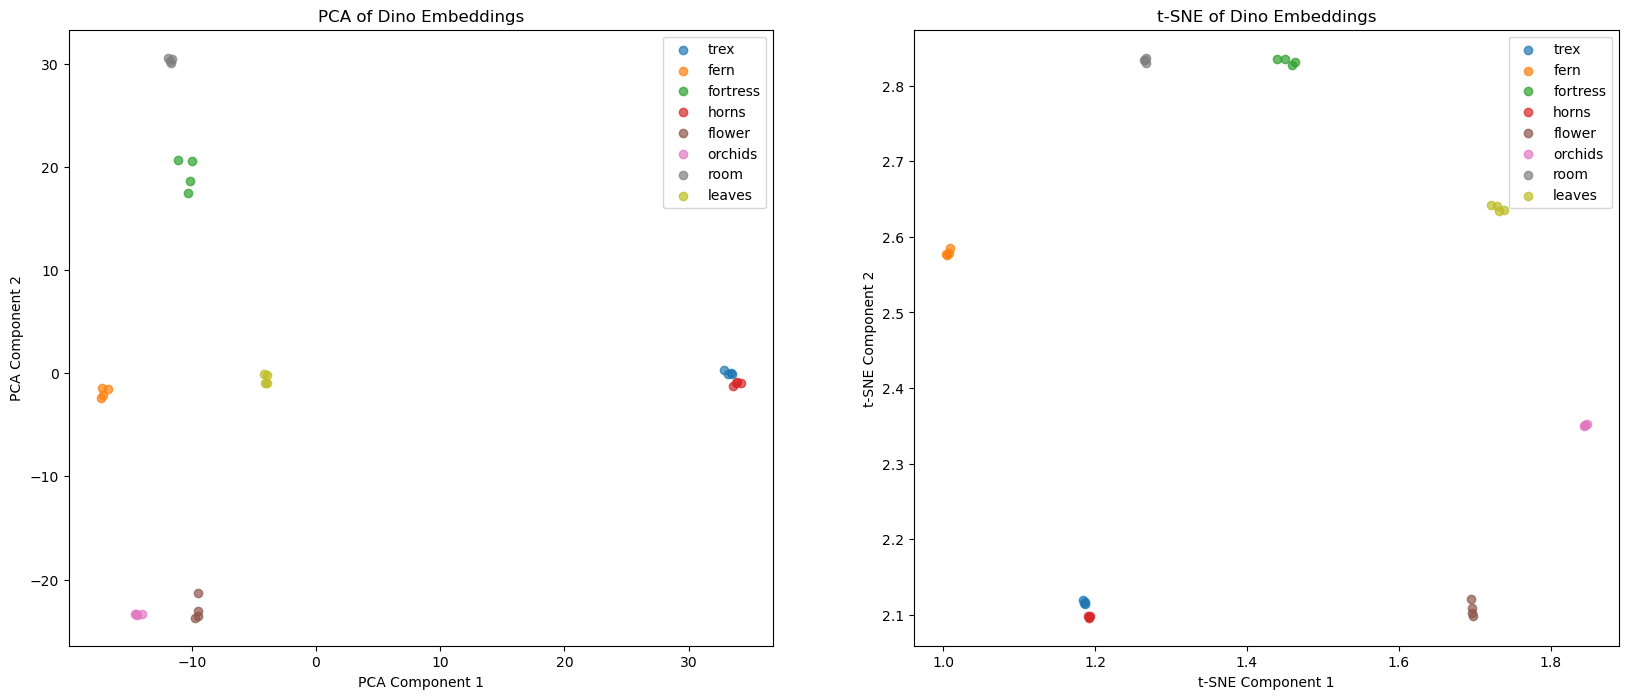

In [11]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_encoded_imgs)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA results on the left
for i, scene in enumerate(unique_scenes):
    scene_mask = np.array(scene_labels) == scene
    axes[0].scatter(pca_results[scene_mask, 0], pca_results[scene_mask, 1], 
                    c=[colors[i]], label=scene, alpha=0.7)

axes[0].set_title('PCA of Dino Embeddings')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].legend()

# Plot t-SNE results on the right
for i, scene in enumerate(unique_scenes):
    scene_mask = np.array(scene_labels) == scene
    axes[1].scatter(tsne_results[scene_mask, 0], tsne_results[scene_mask, 1], 
                    c=[colors[i]], label=scene, alpha=0.7)

axes[1].set_title('t-SNE of Dino Embeddings')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend()

plt.show()
